In [1]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy import stats

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/NY_real_estate/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [4]:
df.shape

(84548, 22)

In [5]:
#dropping highly correlated and unnecessary columns:

drop_cols = ['TAX CLASS AT PRESENT', 'Unnamed: 0', 'NEIGHBORHOOD', 'BOROUGH', 'BLOCK', 'BUILDING CLASS AT PRESENT', 'LOT', 'EASE-MENT', 
            'APARTMENT NUMBER', 'TOTAL UNITS', 'ADDRESS']
df.drop(columns = drop_cols, inplace=True) 

In [6]:
df.head()

,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,07 RENTALS - WALKUP APARTMENTS,10009,5,0,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,07 RENTALS - WALKUP APARTMENTS,10009,28,3,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,07 RENTALS - WALKUP APARTMENTS,10009,16,1,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,07 RENTALS - WALKUP APARTMENTS,10009,10,0,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,07 RENTALS - WALKUP APARTMENTS,10009,6,0,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [7]:
#let's see how many rows have null values:

df.isnull().sum()

BUILDING CLASS CATEGORY           0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [8]:
df.dtypes

BUILDING CLASS CATEGORY           object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [9]:
col = df[0:]
for c in col:
    print("Value counts for " + c)
    print(df[c].value_counts())

Value counts for BUILDING CLASS CATEGORY
01 ONE FAMILY DWELLINGS                         18235
02 TWO FAMILY DWELLINGS                         15828
13 CONDOS - ELEVATOR APARTMENTS                 12989
10 COOPS - ELEVATOR APARTMENTS                  12902
03 THREE FAMILY DWELLINGS                        4384
07 RENTALS - WALKUP APARTMENTS                   3466
09 COOPS - WALKUP APARTMENTS                     2767
04 TAX CLASS 1 CONDOS                            1656
44 CONDO PARKING                                 1441
15 CONDOS - 2-10 UNIT RESIDENTIAL                1281
05 TAX CLASS 1 VACANT LAND                       1248
17 CONDO COOPS                                   1201
22 STORE BUILDINGS                                935
12 CONDOS - WALKUP APARTMENTS                     926
14 RENTALS - 4-10 UNIT                            671
29 COMMERCIAL GARAGES                             587
43 CONDO OFFICE BUILDINGS                         475
31 COMMERCIAL VACANT LAND                

In [10]:
#!pip install pgeocode
import pgeocode

In [11]:
nomi = pgeocode.Nominatim('us') #taking zips for US only here

a = nomi.query_postal_code("10016")

In [12]:
nomi.query_postal_code(10016).longitude

-73.9781

In [13]:
#nomi = pgeocode.Nominatim('us')
nomi.query_postal_code(10016).latitude

40.7443

In [14]:
#a = {zip: [zips]}
#a

In [15]:
unique_zip = df['ZIP CODE'].unique()
a = {'zip': unique_zip}
zip_df = pd.DataFrame(data=a) #can covert dictionaries to DF

In [16]:

zip_ny=zip_df['zip'].apply(nomi.query_postal_code)

In [17]:
zip_ny

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,10009,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7262,-73.9796,4.0
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7152,-73.9877,4.0
3,10011,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7402,-73.9996,4.0
4,10001,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7484,-73.9967,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
181,10304,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.6102,-74.0878,4.0
182,10306,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.5682,-74.1184,4.0
183,10308,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.5518,-74.1526,4.0
184,10309,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.5352,-74.2116,4.0


In [18]:
zip_ny.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,10009,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7262,-73.9796,4.0
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7152,-73.9877,4.0
3,10011,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7402,-73.9996,4.0
4,10001,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7484,-73.9967,4.0


In [19]:
#pd.merge( all_t, score_df.drop(['Sector', 'Industry', 'MarketCap'], axis=1), on='Symbol', how= 'outer' )

In [20]:
#zip_ny[['latitude,'longitude']]

zip_ny=zip_ny.rename(columns={"postal_code": "ZIP CODE"})

In [21]:
zip_ny['ZIP CODE'] = pd.to_numeric(zip_ny['ZIP CODE'], errors='coerce')

In [22]:
zip_ny.info() #checking if zip is numeric here, and it is!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ZIP CODE        186 non-null    int64  
 1   country code    185 non-null    object 
 2   place_name      185 non-null    object 
 3   state_name      185 non-null    object 
 4   state_code      185 non-null    object 
 5   county_name     185 non-null    object 
 6   county_code     185 non-null    float64
 7   community_name  0 non-null      float64
 8   community_code  0 non-null      float64
 9   latitude        185 non-null    float64
 10  longitude       185 non-null    float64
 11  accuracy        185 non-null    float64
dtypes: float64(6), int64(1), object(5)
memory usage: 13.9+ KB


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BUILDING CLASS CATEGORY         84548 non-null  object
 1   ZIP CODE                        84548 non-null  int64 
 2   RESIDENTIAL UNITS               84548 non-null  int64 
 3   COMMERCIAL UNITS                84548 non-null  int64 
 4   LAND SQUARE FEET                84548 non-null  object
 5   GROSS SQUARE FEET               84548 non-null  object
 6   YEAR BUILT                      84548 non-null  int64 
 7   TAX CLASS AT TIME OF SALE       84548 non-null  int64 
 8   BUILDING CLASS AT TIME OF SALE  84548 non-null  object
 9   SALE PRICE                      84548 non-null  object
 10  SALE DATE                       84548 non-null  object
dtypes: int64(5), object(6)
memory usage: 5.2+ MB


In [24]:
#merging two data frames by zip code, adding to the newsly created df_geo, lat and long
zip_ny.head()
df_geo=pd.merge(df, zip_ny[['ZIP CODE','latitude', 'longitude']], on ='ZIP CODE', how = 'left')

In [25]:
#df['ZIP CODE'] = result.apply(get_latitude)
#df['ZIP CODE'] = result.apply(get_longitude)
#df['ZIP CODE'], index = False)


In [26]:
df_geo.describe()

,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,latitude,longitude
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,83566.000000,83566.000000
mean,10731.991614,2.025264,0.193559,1789.322976,1.657485,40.707847,-73.930330
std,1290.879147,16.721037,8.713183,537.344993,0.819341,0.078980,0.102694
min,0.000000,0.000000,0.000000,0.000000,1.000000,40.508500,-74.244500
25%,10305.000000,0.000000,0.000000,1920.000000,1.000000,40.646700,-73.985600
50%,11209.000000,1.000000,0.000000,1940.000000,2.000000,40.711900,-73.944700
75%,11357.000000,2.000000,0.000000,1965.000000,2.000000,40.761100,-73.858500
max,11694.000000,1844.000000,2261.000000,2017.000000,4.000000,40.904500,-73.682800


In [27]:
drop_cols = ['ZIP CODE']
df_geo.drop(columns = drop_cols, inplace=True) 


In [28]:
df_geo.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude
0,07 RENTALS - WALKUP APARTMENTS,5,0,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00,40.7262,-73.9796
1,07 RENTALS - WALKUP APARTMENTS,28,3,4616,18690,1900,2,C7,-,2016-12-14 00:00:00,40.7262,-73.9796
2,07 RENTALS - WALKUP APARTMENTS,16,1,2212,7803,1900,2,C7,-,2016-12-09 00:00:00,40.7262,-73.9796
3,07 RENTALS - WALKUP APARTMENTS,10,0,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00,40.7262,-73.9796
4,07 RENTALS - WALKUP APARTMENTS,6,0,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00,40.7262,-73.9796


In [29]:
df_geo['LAND SQUARE FEET'] = pd.to_numeric(df_geo['LAND SQUARE FEET'], errors='coerce')
df_geo['GROSS SQUARE FEET']= pd.to_numeric(df_geo['GROSS SQUARE FEET'], errors='coerce')
df_geo['SALE PRICE'] = pd.to_numeric(df_geo['SALE PRICE'], errors='coerce')


In [30]:
#let's see how many nulls in sale price

#df_geo['SALE PRICE'].isnull().sum()

In [31]:
df_sale=df_geo.dropna(subset = ['SALE PRICE'], inplace = True)
df_geo.head() #to drop rows with nas from the column sale price


,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude
0,07 RENTALS - WALKUP APARTMENTS,5,0,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00,40.7262,-73.9796
3,07 RENTALS - WALKUP APARTMENTS,10,0,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00,40.7262,-73.9796
4,07 RENTALS - WALKUP APARTMENTS,6,0,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00,40.7262,-73.9796
6,07 RENTALS - WALKUP APARTMENTS,8,0,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00,40.7262,-73.9796
9,08 RENTALS - ELEVATOR APARTMENTS,24,0,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00,40.7262,-73.9796


In [32]:
df_geo['SALE PRICE'].describe()

count    6.998700e+04
mean     1.276456e+06
std      1.140526e+07
min      0.000000e+00
25%      2.250000e+05
50%      5.300000e+05
75%      9.500000e+05
max      2.210000e+09
Name: SALE PRICE, dtype: float64

In [33]:
num_cols = ['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'YEAR BUILT','latitude', 'longitude']

bin_cols = []

cat_cols =  ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'BUILDING CLASS AT TIME OF SALE']
drop_cats = []


In [34]:
#df_geo['latitude'].dtypes

In [35]:
#df_geo['longitude'].dtypes

In [36]:
#df['GROSS SQUARE FEET'].isnull().sum()


In [37]:
#filling NAs with the mean

df_geo['LAND SQUARE FEET']=df_geo['LAND SQUARE FEET'].fillna(df_geo['LAND SQUARE FEET'].mean())
df_geo['GROSS SQUARE FEET']=df_geo['GROSS SQUARE FEET'].fillna(df_geo['GROSS SQUARE FEET'].mean())

<AxesSubplot:>

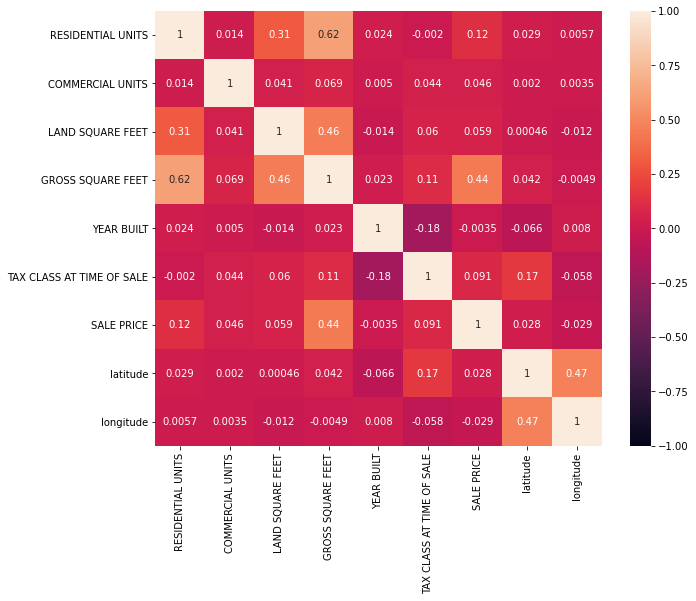

In [38]:
plt.figure(figsize=(10, 8))
corr = df_geo.corr()
sns.heatmap(corr, vmin = -1, annot = True)

In [39]:
corr_sale = corr['SALE PRICE'].sort_values(ascending=False)
corr_sale
#looking at the price and its correlation to other numeric data

SALE PRICE                   1.000000
GROSS SQUARE FEET            0.444408
RESIDENTIAL UNITS            0.119698
TAX CLASS AT TIME OF SALE    0.091352
LAND SQUARE FEET             0.059021
COMMERCIAL UNITS             0.046006
latitude                     0.028052
YEAR BUILT                  -0.003539
longitude                   -0.028848
Name: SALE PRICE, dtype: float64

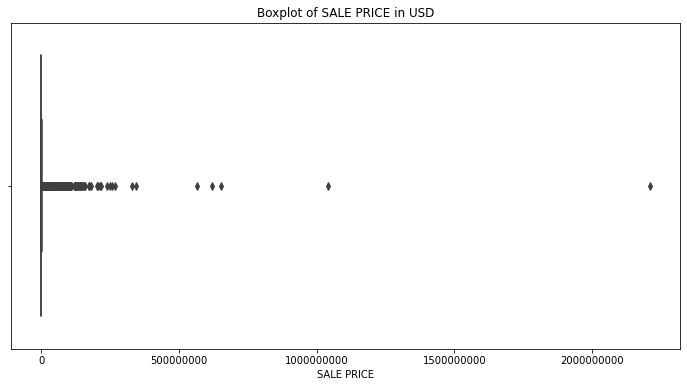

In [40]:
plt.figure(figsize=(12,6))

sns.boxplot(x='SALE PRICE', data=df_geo)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of SALE PRICE in USD')
plt.show()

<AxesSubplot:xlabel='GROSS SQUARE FEET'>

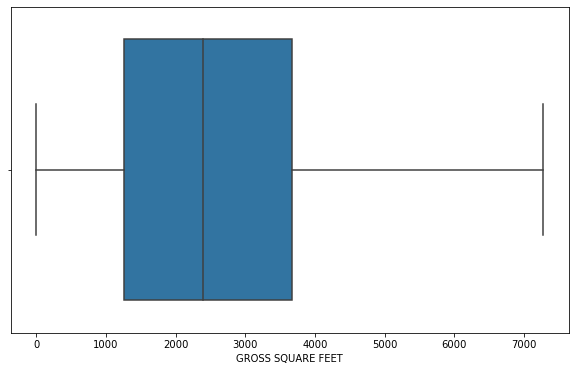

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(x='GROSS SQUARE FEET', data=df_geo,showfliers=False)

<AxesSubplot:xlabel='LAND SQUARE FEET'>

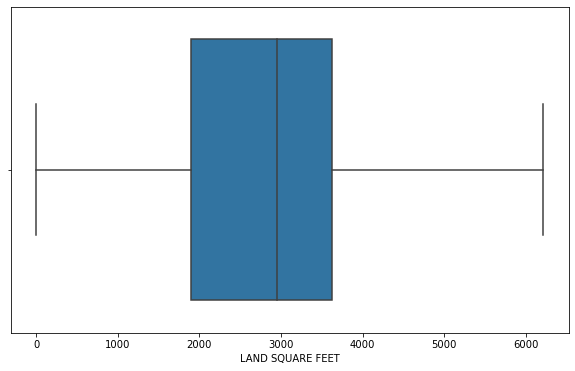

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(x='LAND SQUARE FEET', data=df_geo,showfliers=False)

df_geo = df_geo[df_geo['GROSS SQUARE FEET'] < 10000]
df_geo = df_geo[df_geo['LAND SQUARE FEET'] < 10000]

<AxesSubplot:xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

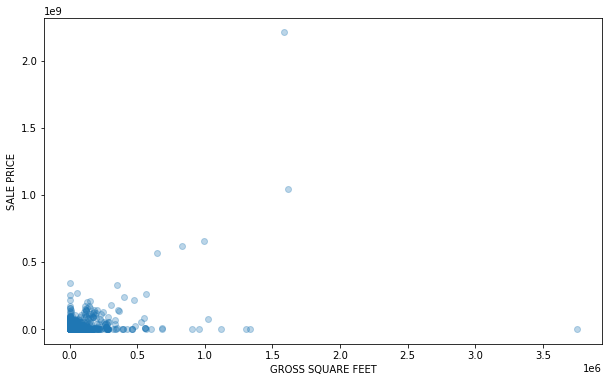

In [43]:
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df_geo, fit_reg=False, scatter_kws={'alpha':0.3})

df_geo = df_geo[(df_geo['SALE PRICE'] > 50000) & (df_geo['SALE PRICE'] <500000)]

<AxesSubplot:xlabel='SALE PRICE'>

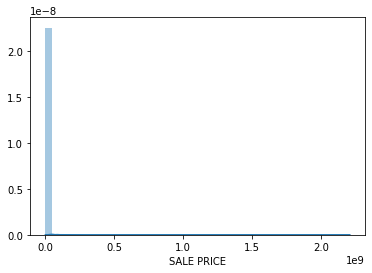

In [44]:
sns.distplot(df_geo['SALE PRICE'])
#right skewed

sales=np.log(df_geo['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

In [45]:
from sklearn import preprocessing
import numpy as np
a = np.random.random((1, 4))
a = a*20
print("Data = ", a)

# normalize the data attributes
normalized = preprocessing.normalize(a)
print("Normalized Data = ", normalized)

Data =  [[ 5.42352498 11.10031655  7.46644245 14.86385523]]
Normalized Data =  [[0.2617546  0.53573255 0.36035155 0.71737154]]


sales=np.log(df['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

sale_price=np.log(df['SALE PRICE'])
print(sale_price.skew())
sns.distplot(sale_price)

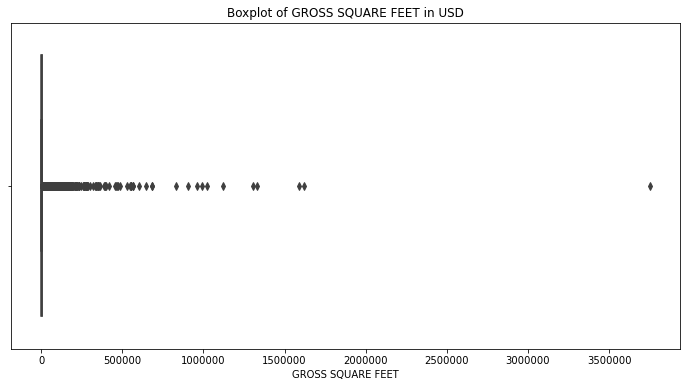

In [46]:
plt.figure(figsize=(12,6))

sns.boxplot(x='GROSS SQUARE FEET', data=df_geo)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Boxplot of GROSS SQUARE FEET in USD')
plt.show()

In [47]:
#see some outliers 

<AxesSubplot:xlabel='GROSS SQUARE FEET', ylabel='SALE PRICE'>

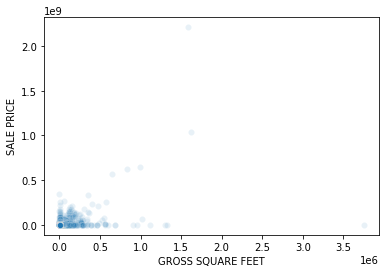

In [48]:
sns.scatterplot('GROSS SQUARE FEET', 'SALE PRICE', data=df_geo, alpha = 0.1)


In [49]:
#df_geo = df_geo[df_geo['GROSS SQUARE FEET'] < 7000]
#df_geo = df_geo[df_geo['LAND SQUARE FEET'] < 10000]

In [50]:
#plt.figure(figsize=(6,4))
#sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE',
           # data=df_geo, fit_reg=False, scatter_kws={'alpha':0.3})

<AxesSubplot:xlabel='LAND SQUARE FEET', ylabel='SALE PRICE'>

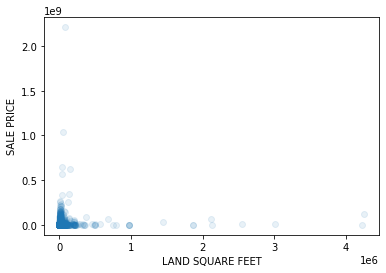

In [51]:
plt.figure(figsize=(6,4))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', 
            data=df_geo, fit_reg=False, scatter_kws={'alpha':0.1})


In [52]:
df_geo[["COMMERCIAL UNITS", "SALE PRICE"]].groupby(['COMMERCIAL UNITS'], 
                                            as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,COMMERCIAL UNITS,SALE PRICE
0,0,65924
1,1,2869
2,2,638
3,3,191
4,4,114
5,5,62
6,6,50
8,8,23
7,7,19
9,9,17


In [53]:
df_geo[["RESIDENTIAL UNITS", "SALE PRICE"]].groupby(['RESIDENTIAL UNITS'], 
                                            as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,RESIDENTIAL UNITS,SALE PRICE
1,1,28414
0,0,20973
2,2,13252
3,3,3839
4,4,1167
...,...,...
107,130,1
106,129,1
105,128,1
104,127,1


In [54]:
df_geo = df_geo[(df_geo['COMMERCIAL UNITS'] > 0) & (df['COMMERCIAL UNITS'] != 2261)] 


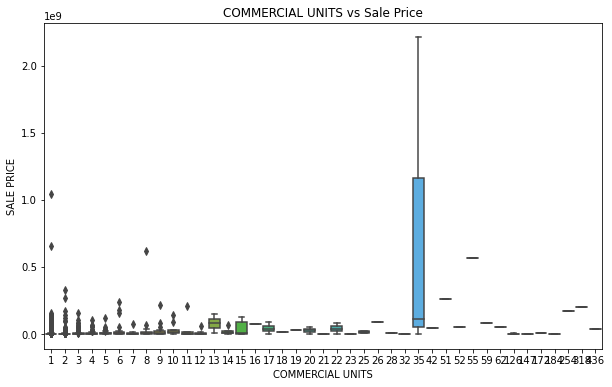

In [55]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=df_geo)
plt.title('COMMERCIAL UNITS vs Sale Price')
plt.show()

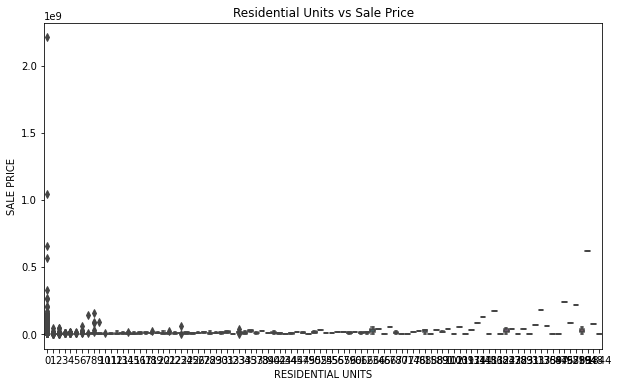

In [56]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=df_geo)
plt.title('Residential Units vs Sale Price')
plt.show()

In [57]:
df_geo['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
df_geo['year'] = df_geo['SALE DATE'].dt.year
df_geo['month'] = df_geo['SALE DATE'].dt.month
df_geo.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude,year,month
172,14 RENTALS - 4-10 UNIT,3,1,1520.000000,3360.000000,1910,2,S3,3300000.0,2016-11-15,40.7262,-73.9796,2016,11
173,14 RENTALS - 4-10 UNIT,4,1,2201.000000,5608.000000,1900,2,S4,7215000.0,2017-01-30,40.7262,-73.9796,2017,1
174,14 RENTALS - 4-10 UNIT,5,1,1779.000000,3713.000000,1910,2,S5,4750000.0,2017-04-03,40.7262,-73.9796,2017,4
187,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,3629.395152,3672.552251,1900,2,R8,2700000.0,2017-07-31,40.7262,-73.9796,2017,7
188,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,3629.395152,3672.552251,1951,2,R8,1500000.0,2017-06-07,40.7262,-73.9796,2017,6


In [58]:
#drop_cols = df['SALE DATE', 'Date'].drop()
df_geo = df_geo.drop(columns=["SALE DATE"])
df_geo.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,latitude,longitude,year,month
172,14 RENTALS - 4-10 UNIT,3,1,1520.000000,3360.000000,1910,2,S3,3300000.0,40.7262,-73.9796,2016,11
173,14 RENTALS - 4-10 UNIT,4,1,2201.000000,5608.000000,1900,2,S4,7215000.0,40.7262,-73.9796,2017,1
174,14 RENTALS - 4-10 UNIT,5,1,1779.000000,3713.000000,1910,2,S5,4750000.0,40.7262,-73.9796,2017,4
187,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,3629.395152,3672.552251,1900,2,R8,2700000.0,40.7262,-73.9796,2017,7
188,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,3629.395152,3672.552251,1951,2,R8,1500000.0,40.7262,-73.9796,2017,6


In [59]:
df_geo['SALE PRICE'] = pd.to_numeric(df_geo['SALE PRICE'], errors='coerce')


In [60]:
df_geo.dropna(subset = ['SALE PRICE'], inplace = True)
df_geo.head() #to drop rows with nas from the column sale price


,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,latitude,longitude,year,month
172,14 RENTALS - 4-10 UNIT,3,1,1520.000000,3360.000000,1910,2,S3,3300000.0,40.7262,-73.9796,2016,11
173,14 RENTALS - 4-10 UNIT,4,1,2201.000000,5608.000000,1900,2,S4,7215000.0,40.7262,-73.9796,2017,1
174,14 RENTALS - 4-10 UNIT,5,1,1779.000000,3713.000000,1910,2,S5,4750000.0,40.7262,-73.9796,2017,4
187,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,3629.395152,3672.552251,1900,2,R8,2700000.0,40.7262,-73.9796,2017,7
188,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,3629.395152,3672.552251,1951,2,R8,1500000.0,40.7262,-73.9796,2017,6


In [61]:
df_geo['SALE PRICE'].dtypes

dtype('float64')

In [62]:
# BUILDING CLASS CATEGORY
print(df_geo['BUILDING CLASS CATEGORY'].nunique())

pivot=df_geo.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot

35


,SALE PRICE
BUILDING CLASS CATEGORY,
01 ONE FAMILY DWELLINGS,450000.0
02 TWO FAMILY DWELLINGS,555000.0
03 THREE FAMILY DWELLINGS,475000.0
04 TAX CLASS 1 CONDOS,0.0
05 TAX CLASS 1 VACANT LAND,5.0
06 TAX CLASS 1 - OTHER,204830.0
07 RENTALS - WALKUP APARTMENTS,4245000.0
08 RENTALS - ELEVATOR APARTMENTS,12960787.0
09 COOPS - WALKUP APARTMENTS,6600000.0


<AxesSubplot:xlabel='BUILDING CLASS CATEGORY'>

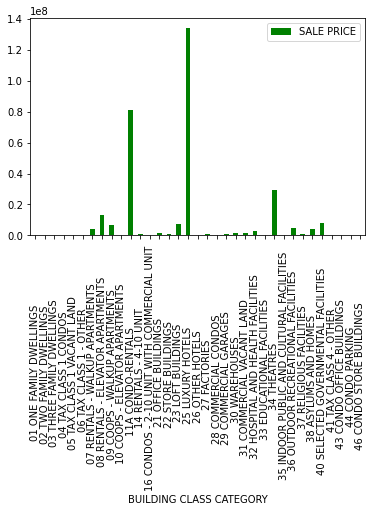

In [63]:
pivot.plot(kind='bar', color='Green')


In [64]:
#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = df_geo[num_cols].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
df_geo[skewed] = np.log1p(df_geo[skewed])

In [65]:
scaler = StandardScaler()
scaler.fit(df_geo[num_cols])
scaled = scaler.transform(df_geo[num_cols])

for i, col in enumerate(num_cols):
       df_geo[col] = scaled[:,i]

In [66]:
df_geo.head()


,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,latitude,longitude,year,month
172,14 RENTALS - 4-10 UNIT,3,1,-0.526006,-0.150593,-0.142559,2,S3,3300000.0,0.291283,-0.547691,2016,11
173,14 RENTALS - 4-10 UNIT,4,1,-0.272815,0.128980,-0.218332,2,S4,7215000.0,0.291283,-0.547691,2017,1
174,14 RENTALS - 4-10 UNIT,5,1,-0.418403,-0.096074,-0.142559,2,S5,4750000.0,0.291283,-0.547691,2017,4
187,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,0.069320,-0.102051,-0.218332,2,R8,2700000.0,0.291283,-0.547691,2017,7
188,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,0.069320,-0.102051,0.168111,2,R8,1500000.0,0.291283,-0.547691,2017,6


In [67]:
#Select the variables to be one-hot encoded
one_hot_features = ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS']

In [68]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(df_geo[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4062 entries, 172 to 84547
Data columns (total 164 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   TAX CLASS AT TIME OF SALE                                             4062 non-null   int64
 1   RESIDENTIAL UNITS                                                     4062 non-null   int64
 2   COMMERCIAL UNITS                                                      4062 non-null   int64
 3   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       4062 non-null   uint8
 4   BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                       4062 non-null   uint8
 5   BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                     4062 non-null   uint8
 6   BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS                         4062 non-null   uint8
 7   BUILDING CL

In [69]:
# Replacing categorical columns with dummies
fdf = df_geo.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)

In [70]:
df_geo.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,latitude,longitude,year,month
172,14 RENTALS - 4-10 UNIT,3,1,-0.526006,-0.150593,-0.142559,2,S3,3300000.0,0.291283,-0.547691,2016,11
173,14 RENTALS - 4-10 UNIT,4,1,-0.272815,0.128980,-0.218332,2,S4,7215000.0,0.291283,-0.547691,2017,1
174,14 RENTALS - 4-10 UNIT,5,1,-0.418403,-0.096074,-0.142559,2,S5,4750000.0,0.291283,-0.547691,2017,4
187,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,0.069320,-0.102051,-0.218332,2,R8,2700000.0,0.291283,-0.547691,2017,7
188,16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,0,1,0.069320,-0.102051,0.168111,2,R8,1500000.0,0.291283,-0.547691,2017,6


In [73]:
df_geo.dtypes

BUILDING CLASS CATEGORY            object
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
LAND SQUARE FEET                  float64
GROSS SQUARE FEET                 float64
YEAR BUILT                        float64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
latitude                          float64
longitude                         float64
year                                int64
month                               int64
dtype: object

In [74]:
df_geo['BUILDING CLASS CATEGORY '] = pd.to_numeric(df_geo['BUILDING CLASS CATEGORY '], errors='coerce')

KeyError: 'BUILDING CLASS CATEGORY '

In [75]:
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4062 entries, 172 to 84547
Columns: 172 entries, LAND SQUARE FEET to BUILDING CLASS AT TIME OF SALE_Z9
dtypes: float64(6), int64(5), uint8(161)
memory usage: 1019.5 KB


train test split

In [76]:
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)

X_fdf.shape , Y_fdf.shape

((4062, 171), (4062,))

In [77]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.2 , random_state =55)

In [78]:
X_train.shape , Y_train.shape


((3249, 171), (3249,))

In [79]:
X_test.shape , Y_test.shape


((813, 171), (813,))

modeling

In [80]:
#root mean square error:

def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [81]:
y = df_geo['SALE PRICE']
X = df_geo[['latitude', 'longitude'] + one_hot_features]

In [82]:
from sklearn.linear_model import LinearRegression

In [83]:
lrm = LinearRegression()
lrm.fit(X, y)

ValueError: could not convert string to float: '14 RENTALS - 4-10 UNIT                     '

In [84]:
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

AttributeError: 'LinearRegression' object has no attribute 'coef_'